In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys;sys.path.append("..")
import pandas as pd
import numpy as np
import tqdm
import socceraction
import socceraction.spadl
import matplotsoccer
import urllib
import zipfile
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# PART 1:  DOWNLOAD STATSBOMB DATA AND CONVERT TO SPADL
Currently compatible with StatsBomb data 4.0.0 as of July 17, 2019

In [2]:
datafolder = "../data"

statsbombzip = os.path.join(datafolder,"statsbomb-open-data.zip")
statsbombraw = os.path.join(datafolder,"statsbomb-raw")
statsbombjson =  os.path.join(statsbombraw,"open-data-master","data")

statsbombh5 = os.path.join(datafolder,"statsbomb.h5")
spadlh5 = os.path.join(datafolder,"spadl-statsbomb.h5")

### Download and extract the Statsbomb event data

In [3]:
url = "https://github.com/statsbomb/open-data/archive/master.zip"
urllib.request.urlretrieve(url, statsbombzip)

('../data/statsbomb-open-data.zip',
 <http.client.HTTPMessage at 0x7f84648409e8>)

In [4]:
with zipfile.ZipFile(statsbombzip, 'r') as zipObj:
    zipObj.extractall(statsbombraw)

### Convert raw Statsbomb json files to Statsbomb HDF5 file

In [5]:
%%time
socceraction.spadl.statsbombjson_to_statsbombh5(statsbombjson,statsbombh5)

/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
converting events files to ../data/statsbomb.h5: 100%|██████████| 336/336 [01:13<00:00,  4.26it/s]

CPU times: user 1min 26s, sys: 1.42 s, total: 1min 27s
Wall time: 1min 27s


In [6]:
# uncomment to inspect the data
matches = pd.read_hdf(statsbombh5,"matches")
players = pd.read_hdf(statsbombh5,"players")
teams = pd.read_hdf(statsbombh5,"teams")
competitions = pd.read_hdf(statsbombh5,"competitions")
match_id = matches.match_id[0]
events = pd.read_hdf(statsbombh5,f"events/match_{match_id}")

#matches.columns
#players[:5]
#teams[:5]
#competitions[:5]
#events[:5]

### Convert Statsbomb data (in a HDF5 file) to the SPADL format (in a HDF5 file)

In [7]:
socceraction.spadl.statsbombh5_to_spadlh5(statsbombh5,spadlh5)

converting statsbomb events to spadl actions: 100%|██████████| 335/335 [03:21<00:00,  1.64it/s]


In [8]:
# uncomment to inspect the data

games = pd.read_hdf(spadlh5,"games")
players = pd.read_hdf(spadlh5,"players")
teams = pd.read_hdf(spadlh5,"teams")
competitions = pd.read_hdf(spadlh5,"competitions")
actiontypes = pd.read_hdf(spadlh5, "actiontypes")
bodyparts = pd.read_hdf(spadlh5, "bodyparts")
results = pd.read_hdf(spadlh5, "results")

game_id = games.game_id[0]
actions = pd.read_hdf(spadlh5,f"actions/game_{game_id}")

#games[:5].dtypes
#players[:5].dtypes
#teams[:5].dtypes
#competitions[:5]
#actions[:5]

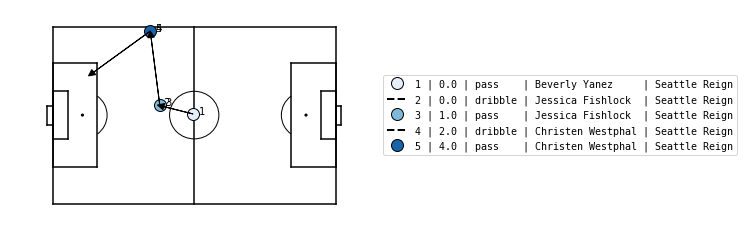

In [9]:
# Plot statsbomb data
games = pd.read_hdf(spadlh5,"games")
players = pd.read_hdf(spadlh5,"players")
teams = pd.read_hdf(spadlh5,"teams")
competitions = pd.read_hdf(spadlh5,"competitions")
actiontypes = pd.read_hdf(spadlh5, "actiontypes")
bodyparts = pd.read_hdf(spadlh5, "bodyparts")
results = pd.read_hdf(spadlh5, "results")

game_id = games.game_id[10]
actions = pd.read_hdf(spadlh5,f"actions/game_{game_id}")
actions = (
    actions.merge(actiontypes)
    .merge(results)
    .merge(bodyparts)
    .merge(players,"left",on="player_id")
    .merge(teams,"left",on="team_id")
    .sort_values(["period_id", "time_seconds", "timestamp"])
    .reset_index(drop=True)
)

a = actions[0:5]
labels = a[["time_seconds","type_name","player_name","team_name"]]
matplotsoccer.actions(location=a[["start_x","start_y","end_x","end_y"]],
                    action_type = a.type_name,
                    team=a.team_name,
                    result = a.result_name,
                    label=labels,
                    zoom=False)

# PART 2: COMPUTE SPADL VALUES OF ALL ACTIONS IN A COMPETITION

### Select a competition and choose file names for the features, labels and predictions

In [10]:
games = pd.read_hdf(spadlh5,"games")
games = games[games.competition_name == "FIFA World Cup"]
print("nb of games:", len(games))


featuresh5 = os.path.join(datafolder,"features-statsbomb.h5")
labelsh5 = os.path.join(datafolder,"labels-statsbomb.h5")
predictionsh5 =  os.path.join(datafolder,"predictions-statsbomb.h5")

nb of games: 64


## Generate and store all SPADL features

In [11]:
import socceraction.classification.features as fs

actiontypes = pd.read_hdf(spadlh5, "actiontypes")
bodyparts = pd.read_hdf(spadlh5, "bodyparts")
results = pd.read_hdf(spadlh5, "results")

xfns = [fs.actiontype,
       fs.actiontype_onehot,
       fs.bodypart,
       fs.bodypart_onehot,
       fs.result,
       fs.result_onehot,
       fs.goalscore,
       fs.startlocation,
       fs.endlocation,
       fs.movement,
       fs.space_delta,
       fs.startpolar,
       fs.endpolar,
       fs.team,
       fs.time,
       fs.time_delta
      ]

for game in tqdm.tqdm(list(games.itertuples()),desc=f"Generating and storing features in {featuresh5}"):
    actions = pd.read_hdf(spadlh5,f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes)
        .merge(results)
        .merge(bodyparts)
        .sort_values(["period_id", "time_seconds", "timestamp"])
        .reset_index(drop=True)
    )
    gamestates = fs.gamestates(actions,3)
    gamestates = fs.play_left_to_right(gamestates,game.home_team_id)
    
    X = pd.concat([fn(gamestates) for fn in xfns],axis=1)
    X.to_hdf(featuresh5,f"game_{game.game_id}")

Generating and storing features in ../data/features-statsbomb.h5: 100%|██████████| 64/64 [00:21<00:00,  2.91it/s]


## Generate and store all SPADL labels

In [12]:
import socceraction.classification.labels as lab

actiontypes = pd.read_hdf(spadlh5, "actiontypes")
bodyparts = pd.read_hdf(spadlh5, "bodyparts")
results = pd.read_hdf(spadlh5, "results")

yfns = [lab.scores,lab.concedes,lab.goal_from_shot]

for game in tqdm.tqdm(list(games.itertuples()),desc=f"Computing and storing labels in {labelsh5}"):
    actions = pd.read_hdf(spadlh5,f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes)
        .merge(results)
        .merge(bodyparts)
        .sort_values(["period_id", "time_seconds", "timestamp"])
        .reset_index(drop=True)
    )
    
    Y = pd.concat([fn(actions) for fn in yfns],axis=1)
    Y.to_hdf(labelsh5,f"game_{game.game_id}")

Computing and storing labels in ../data/labels-statsbomb.h5: 100%|██████████| 64/64 [00:11<00:00,  5.54it/s]


# Solve two classication problems
1. select feature set X 
2. select labels Y_scores and Y_concedes
3. train classifiers F(X) = Y

In [13]:
# 1. Select feature set X
xfns = [#fs.actiontype,
       fs.actiontype_onehot,
       #fs.bodypart,
       #fs.bodypart_onehot,
       #fs.result,
       fs.result_onehot,
       fs.goalscore,
       #fs.startlocation,
       #fs.endlocation,
       #fs.movement,
       #fs.space_delta,
       #fs.startpolar,
       fs.endpolar,
       #fs.team,
       fs.time,
       #fs.time_delta,
       #fs.actiontype_result_onehot
      ]
nb_prev_actions = 1

# generate the columns of the selected features
Xcols = fs.feature_column_names(xfns,nb_prev_actions)
X = []
for game_id in tqdm.tqdm(games.game_id,desc="selecting features"):
    Xi = pd.read_hdf(featuresh5,f"game_{game_id}")
    X.append(Xi[Xcols])
X = pd.concat(X)

# 2. Select label Y
Ycols = ["scores","concedes"]
Y = []
for game_id in tqdm.tqdm(games.game_id,desc="selecting label"):
    Yi = pd.read_hdf(labelsh5,f"game_{game_id}")
    Y.append(Yi[Ycols])
Y = pd.concat(Y)
print("X:", list(X.columns))
print("Y:", list(Y.columns))

selecting label: 100%|██████████| 64/64 [00:00<00:00, 128.93it/s]

X: ['type_pass_a0', 'type_cross_a0', 'type_throw_in_a0', 'type_freekick_crossed_a0', 'type_freekick_short_a0', 'type_corner_crossed_a0', 'type_corner_short_a0', 'type_take_on_a0', 'type_foul_a0', 'type_tackle_a0', 'type_interception_a0', 'type_shot_a0', 'type_shot_penalty_a0', 'type_shot_freekick_a0', 'type_keeper_save_a0', 'type_keeper_claim_a0', 'type_keeper_punch_a0', 'type_keeper_pick_up_a0', 'type_clearance_a0', 'type_bad_touch_a0', 'type_non_action_a0', 'type_dribble_a0', 'type_goalkick_a0', 'result_fail_a0', 'result_success_a0', 'result_offside_a0', 'result_owngoal_a0', 'result_yellow_card_a0', 'result_red_card_a0', 'goalscore_team', 'goalscore_opponent', 'goalscore_diff', 'end_dist_to_goal_a0', 'end_tan_angle_to_goal_a0', 'period_id_a0', 'time_seconds_a0', 'time_seconds_overall_a0']
Y: ['scores', 'concedes']


In [14]:
%%time

# 3. train classifiers F(X) = Y

import xgboost

Y_pred = pd.DataFrame()
for col in list(Y.columns):
    model = xgboost.XGBClassifier()
    model.fit(X,Y[col])
    Y_pred[col] = [p[1] for p in model.predict_proba(X)]

CPU times: user 19.7 s, sys: 492 ms, total: 20.2 s
Wall time: 20.2 s


In [15]:
from sklearn.metrics import brier_score_loss, roc_auc_score
for col in list(Y.columns):
    print(f"Y: {col}")
    print(f"Brier score: %.4f" % brier_score_loss(Y[col],Y_pred[col]))
    print(f"ROC AUC: %.4f" % roc_auc_score(Y[col],Y_pred[col]))

Y: scores
Brier score: 0.0090
ROC AUC: 0.8719
Y: concedes
Brier score: 0.0023
ROC AUC: 0.9079


# Save action predictions per game

In [16]:
# get rows with game id per action
A = []
for game_id in tqdm.tqdm(games.game_id,"loading game ids"):
    Ai = pd.read_hdf(spadlh5,f"actions/game_{game_id}")
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A,Y_pred],axis=1).groupby("game_id")
for k,df in tqdm.tqdm(grouped_predictions,desc="saving predictions per game"):
    df = df.reset_index(drop=True)
    df[Y_pred.columns].to_hdf(predictionsh5,f"game_{int(k)}")

saving predictions per game: 100%|██████████| 64/64 [00:00<00:00, 104.80it/s]


## Compute and inspect VAEP values

In [17]:
import socceraction.vaep as vaep

players = pd.read_hdf(spadlh5,"players")
teams = pd.read_hdf(spadlh5,"teams")
actiontypes = pd.read_hdf(spadlh5, "actiontypes")
bodyparts = pd.read_hdf(spadlh5, "bodyparts")
results = pd.read_hdf(spadlh5, "results")

A = []
for game in tqdm.tqdm(list(games.itertuples())):
    actions = pd.read_hdf(spadlh5,f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes)
        .merge(results)
        .merge(bodyparts)
        .merge(players,"left",on="player_id")
        .merge(teams,"left",on="team_id")
        .sort_values(["period_id", "time_seconds", "timestamp"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(predictionsh5,f"game_{game.game_id}")
    values = vaep.value(actions,preds.scores,preds.concedes)
    A.append(pd.concat([actions,preds,values],axis=1))
A = pd.concat(A).sort_values(["game_id","period_id", "time_seconds", "timestamp"]).reset_index(drop=True)

100%|██████████| 64/64 [00:05<00:00, 11.05it/s]


### inspect Belgium's top 10 most valuable non-shot actions

2018-06-23 Belgium 5-2 Tunisia 89' cross Youri Tielemans


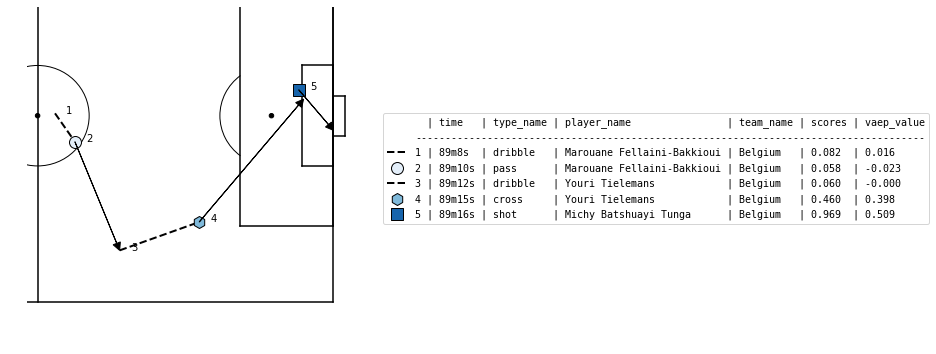

2018-06-28 England 0-1 Belgium 9' dribble Michy Batshuayi Tunga


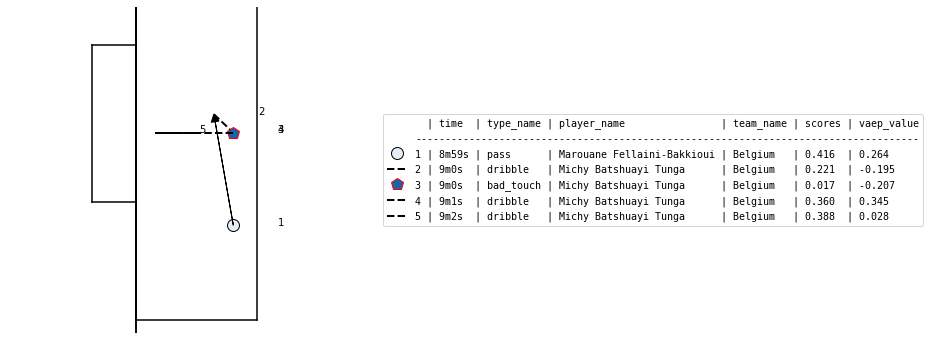

2018-07-14 Belgium 2-0 England 3' cross Nacer Chadli


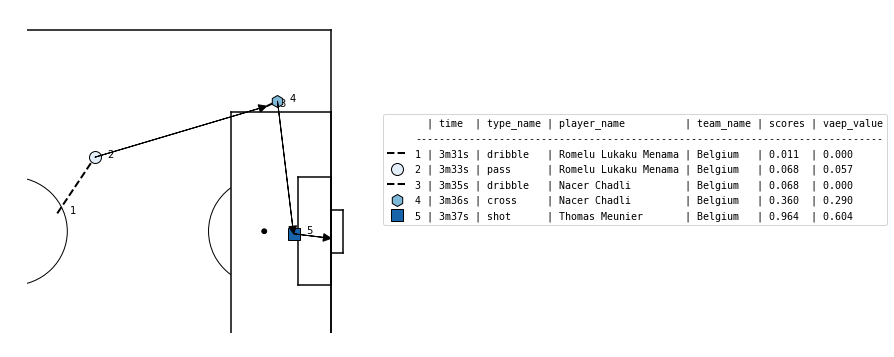

2018-07-10 France 1-0 Belgium 46' pass Axel Witsel


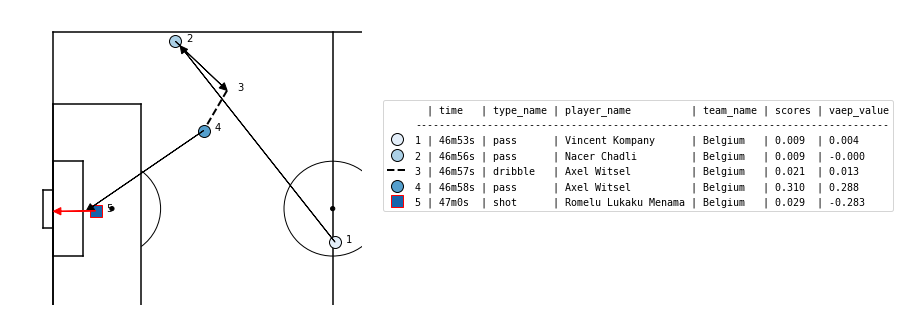

2018-06-23 Belgium 5-2 Tunisia 46' cross Kevin De Bruyne


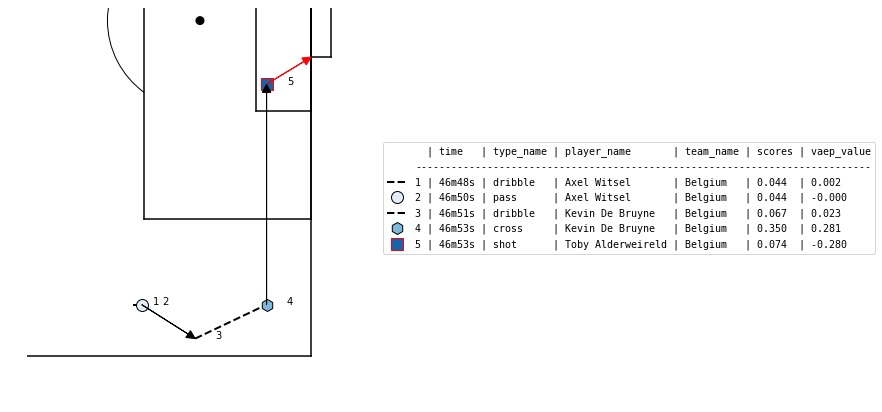

2018-06-28 England 0-1 Belgium 8' pass Marouane Fellaini-Bakkioui


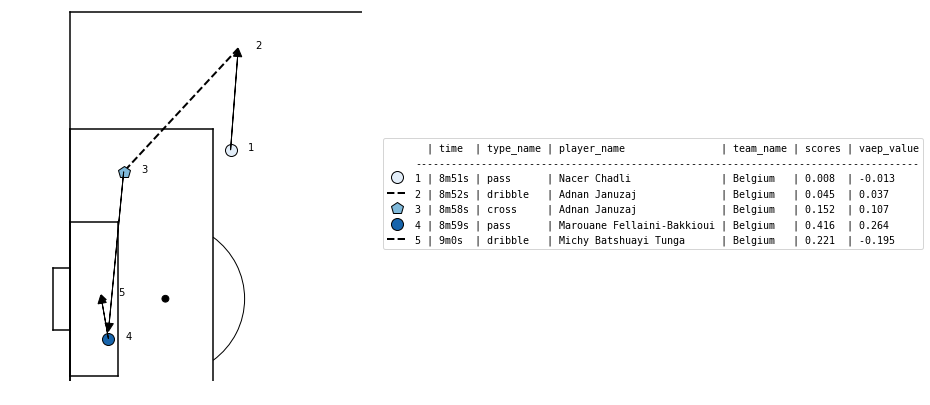

2018-06-23 Belgium 5-2 Tunisia 91' dribble Michy Batshuayi Tunga


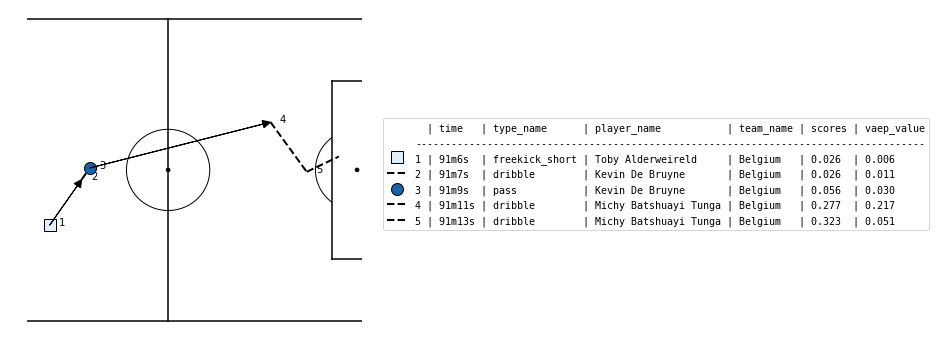

2018-07-02 Belgium 3-2 Japan 73' cross Eden Hazard


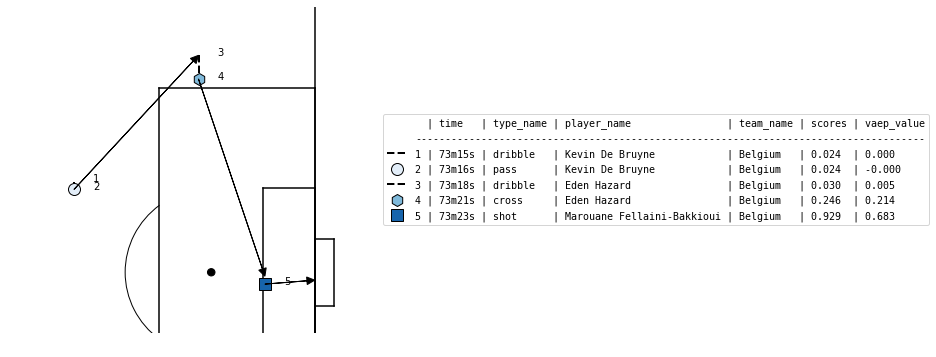

2018-07-10 France 1-0 Belgium 21' corner_crossed Nacer Chadli


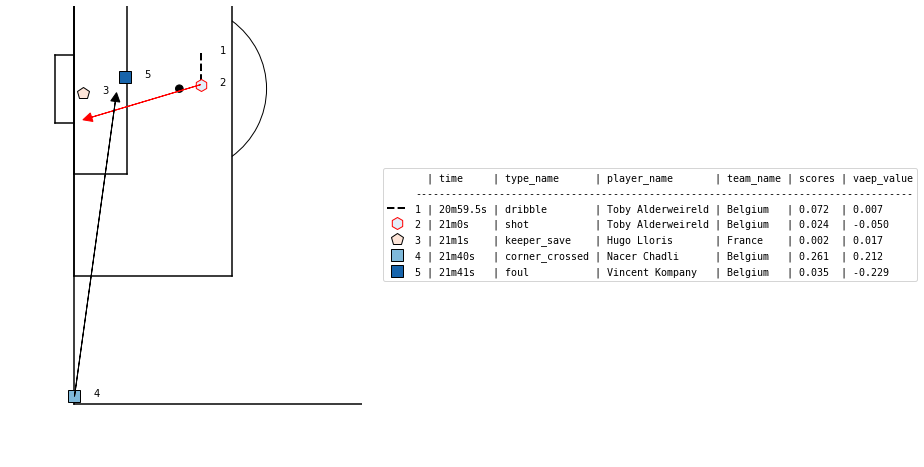

2018-06-23 Belgium 5-2 Tunisia 50' dribble Eden Hazard


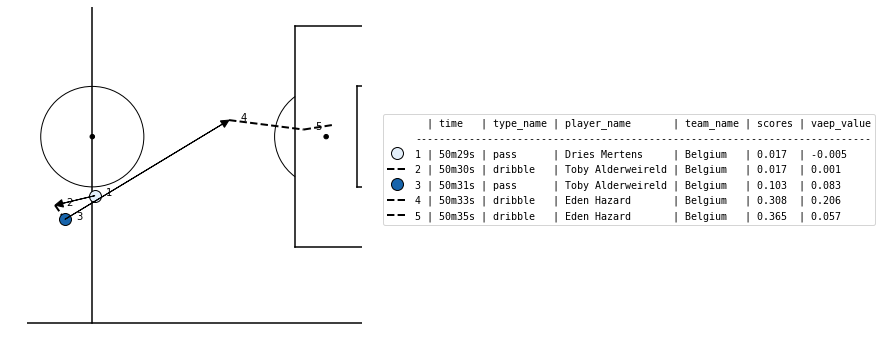

In [19]:
import matplotsoccer
sorted_A = A.sort_values("vaep_value", ascending=False)
sorted_A = sorted_A[sorted_A.team_name == "Belgium"] # view only actions from Belgium
sorted_A = sorted_A[~sorted_A.type_name.str.contains("shot")] #eliminate shots


def get_time(period_id,time_seconds):
    m = int((period_id-1)*45 + time_seconds // 60)
    s = time_seconds % 60
    if s == int(s):
        s = int(s)
    return f"{m}m{s}s"

i = 0
for j in range(i,i+10):
    row = list(sorted_A[j:j+1].itertuples())[0]
    i = row.Index
    a = A[i - 3 : i+2].copy()
    
    g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
    game_info = f"{g.match_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name}"
    minute = int((row.period_id-1)*45 + row.time_seconds // 60)
    print(f"{game_info} {minute}' {row.type_name} {row.player_name}")

    a["scores"] = a.scores.apply(lambda x : "%.3f" % x )
    a["vaep_value"] = a.vaep_value.apply(lambda x : "%.3f" % x )
    a["time"] = a[["period_id","time_seconds"]].apply(lambda x: get_time(*x),axis=1)
    cols = ["time","type_name","player_name","team_name","scores","vaep_value"]
    matplotsoccer.actions(a[["start_x","start_y","end_x","end_y"]],
                a.type_name,
                team=a.team_name,
                result = a.result_name == "success",
                label=a[cols],
                labeltitle = cols,
                zoom=True)